In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from tqdm import tqdm

import cv2

In [ ]:
# Set path for data source
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Load Diffusion/dataset/")

Mounted at /content/gdrive


In [ ]:
# Set the path to the folder containing saved files
load_path = "./preprocessed_data_168x168_2years"

# Load saved NumPy arrays
X_train = np.load(os.path.join(load_path, 'X_train.npy'))
X_test = np.load(os.path.join(load_path, 'X_test.npy'))
y_train = np.load(os.path.join(load_path, 'y_train.npy'))
y_test = np.load(os.path.join(load_path, 'y_test.npy'))

# Load saved Pandas DataFrames
train_data = pd.read_pickle(os.path.join(load_path, 'train_data.pkl'))
test_data = pd.read_pickle(os.path.join(load_path, 'test_data.pkl'))
metadata = pd.read_pickle(os.path.join(load_path, 'metadata.pkl'))
metadata_original = pd.read_pickle(os.path.join(load_path, 'metadata_original.pkl'))

In [ ]:
def merge_dummified_columns(df, dummified_columns, new_column_name):
    """
    Merges dummified columns into a single column in a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the dummified columns.
        dummified_columns (list): A list of the names of the dummified columns.
        new_column_name (str): The name of the new column to create.

    Returns:
        pd.DataFrame: The DataFrame with the dummified columns merged into a single new column.
    """
    # Create a new column containing the column name where the value is 1 for each row
    df[new_column_name] = df[dummified_columns].idxmax(axis=1)

    # Drop the dummified columns
    df.drop(dummified_columns, axis=1, inplace=True)

    return df

test_metadata = metadata_original.loc[test_data.columns]

test_metadata = merge_dummified_columns(test_metadata,
                     dummified_columns=['chilledwater', 'electricity', 'gas', 'hotwater', 'steam'],
                     new_column_name='meter_type')
test_metadata = merge_dummified_columns(test_metadata,
                     dummified_columns=['Education', 'Entertainment/public assembly', 'Lodging/residential', 'Office', 'Public services'],
                     new_column_name='building_type')

test_metadata


,lat,lng,year,meter_type,building_type
electricity_Lamb_office_Caitlin_2016,51.497838,-3.186246,2016,electricity,Office
electricity_Rat_public_Kelle_2016,38.903504,-77.005349,2016,electricity,Public services
electricity_Rat_assembly_Ezequiel_2016,38.903504,-77.005349,2016,electricity,Entertainment/public assembly
electricity_Bear_assembly_Roxy_2016,37.871903,-122.260729,2016,electricity,Entertainment/public assembly
gas_Shrew_office_Rose_2017,51.499840,-0.124663,2017,gas,Office
...,...,...,...,...,...
steam_Moose_education_Omar_2016,45.421500,-75.697200,2016,steam,Education
electricity_Rat_public_Chrissy_2017,38.903504,-77.005349,2017,electricity,Public services
electricity_Hog_office_Merilyn_2016,44.978782,-93.255398,2016,electricity,Office
steam_Bull_assembly_Amalia_2016,30.267200,-97.743100,2016,steam,Entertainment/public assembly


In [ ]:
def load_dataset_images(model_name):
    # Specify the path where the datasets are saved
    generation_path = "./generation/" + model_name + '_168x168'

    # Check if the path exists
    if not os.path.exists(generation_path):
        raise FileNotFoundError(f"The specified path {generation_path} does not exist.")

    # Initialize an empty list to store np.arrays
    dataset_images = []
    dataset_series = []

    # Loop through each file in the directory
    for file_name in tqdm([item for item in os.listdir(generation_path) if item.startswith('generated_images_seed')]):
        # Construct the complete file path
        file_path = os.path.join(generation_path, file_name)

        # Check if the file is a numpy file (.npy)
        if file_path.endswith('.npy'):
            # Load the dataset
            generated_images = np.load(file_path)
            images_seed = int(file_name.split('.')[0].split('_')[-1])

            # Set the target shape
            target_shape = (generated_images.shape[0], 52, 168, 1)

            # Initialize an array to hold the resized images
            resized_images = np.zeros(target_shape)

            # Loop through each image to resize it
            for i in range(generated_images.shape[0]):
                resized_image = cv2.resize(generated_images[i], (168, 52))  # Note the dimensions are (width, height)
                resized_images[i] = np.expand_dims(resized_image, axis=-1)  # Add back the last dimension

            # Assume resized_images has a shape of (905, 52, 168, 1)
            generated_series = resized_images.reshape(generated_images.shape[0], -1).T  # Transpose to get shape (8736, 905)
            generated_series = np.expand_dims(generated_series, axis=-1)

            # Append the loaded array to the list
            dataset_images.append(generated_images)
            dataset_series.append(generated_series)

        else:
            print(f"Skipping non-numpy file: {file_name}")

    # Concatenate along the last dimension (axis=-1)
    dataset_images = np.concatenate(dataset_images, axis=-1)
    dataset_series = np.concatenate(dataset_series, axis=-1)

    return dataset_images, dataset_series

In [ ]:
CVAE_images, CVAE_series = load_dataset_images(model_name='CVAE_mse')
CGAN_images, CGAN_series = load_dataset_images(model_name='CGAN')
Diffusion_images, Diffusion_series = load_dataset_images(model_name='diffusion_model')

100%|██████████| 30/30 [05:50<00:00, 11.69s/it]


In [ ]:
test_metadata_groupby = test_metadata.copy()
test_metadata_groupby['count'] = 1
test_metadata_groupby = test_metadata_groupby.groupby(['lat','lng','meter_type','building_type','year']).count().sort_values('count',ascending=False)

test_metadata_groupby

count
lat       lng         meter_type  building_type                 year       
38.903504 -77.005349  electricity Education                     2016     23
                                                                2017     23
                                  Public services               2016     22
                                                                2017     20
51.497838 -3.186246   gas         Education                     2017     19
...                                                                     ...
37.871903 -122.260729 electricity Entertainment/public assembly 2017      1
37.406733 -77.806130  steam       Lodging/residential           2017      1
28.517689 -81.379039  gas         Education                     2017      1
37.406733 -77.806130  hotwater    Public services               2016      1
53.349800  6.260300   gas         Office                        2017      1

[199 rows x 1 columns]

In [ ]:
selected_meta = test_metadata_groupby.head(20)
selected_meta = selected_meta.reset_index()
selected_meta

,lat,lng,meter_type,building_type,year,count
0,38.903504,-77.005349,electricity,Education,2016,23
1,38.903504,-77.005349,electricity,Education,2017,23
2,38.903504,-77.005349,electricity,Public services,2016,22
3,38.903504,-77.005349,electricity,Public services,2017,20
4,51.497838,-3.186246,gas,Education,2017,19
5,30.267200,-97.743100,steam,Education,2017,18
6,30.267200,-97.743100,chilledwater,Education,2016,17
7,44.978782,-93.255398,electricity,Office,2017,17
8,33.424425,-111.928140,electricity,Education,2016,15
9,33.424425,-111.928140,chilledwater,Education,2016,15


In [ ]:
test_data = (test_data-test_data.mean())/test_data.std()

In [ ]:
selected_meta = test_metadata_groupby.head(20)
selected_meta = selected_meta.reset_index()
selected_meta = selected_meta.loc[[7, 15, 9, 5]]
selected_meta

,lat,lng,meter_type,building_type,year,count
7,44.978782,-93.255398,electricity,Office,2017,17
15,30.267200,-97.743100,electricity,Education,2016,14
9,33.424425,-111.928140,chilledwater,Education,2016,15
5,30.267200,-97.743100,steam,Education,2017,18


In [ ]:
CVAE_images.shape

(901, 168, 168, 30)

In [ ]:
CVAE_series.shape

(8736, 901, 30)

In [ ]:
def series_preprocessing(input_series):
  output_series = input_series.copy()

  output_series = output_series[:,:,0]
  output_series = pd.DataFrame(output_series)
  output_series.columns = test_data.columns
  output_series = (output_series-output_series.min())/(output_series.max()-output_series.min())
  return output_series

Electricity meters in Office buildings at (lat: 44.98, lon: -93.26)


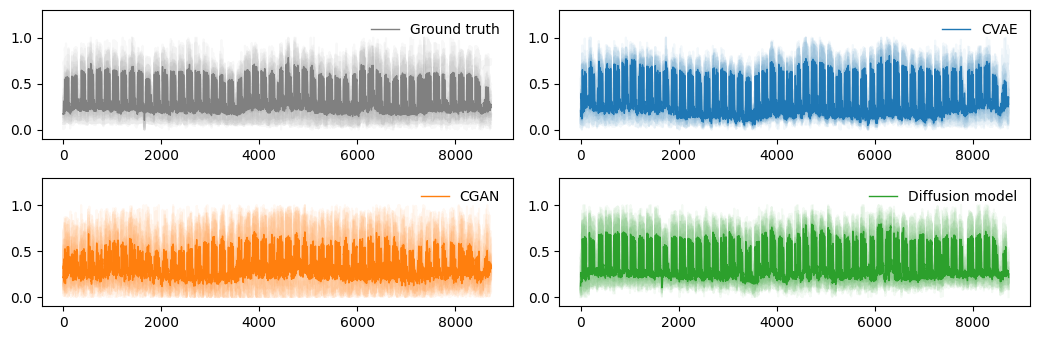

Electricity meters in Education buildings at (lat: 30.27, lon: -97.74)


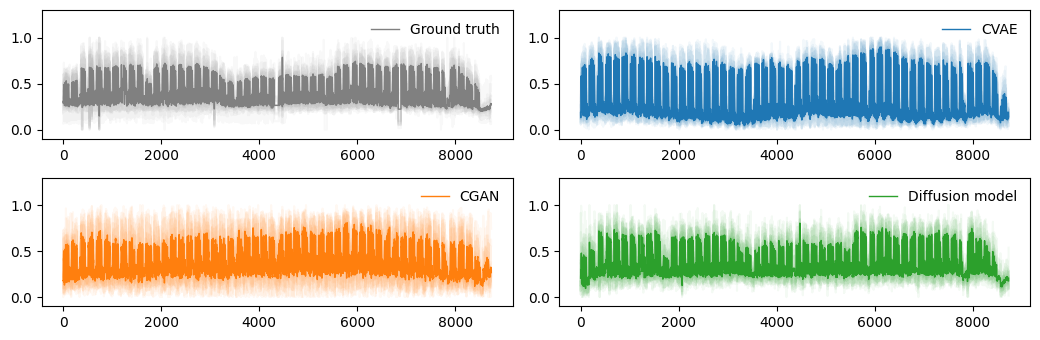

Chilledwater meters in Education buildings at (lat: 33.42, lon: -111.93)


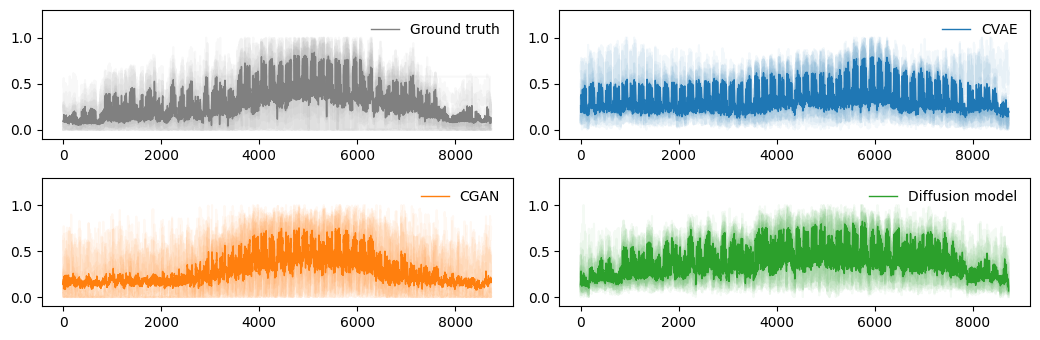

Steam meters in Education buildings at (lat: 30.27, lon: -97.74)


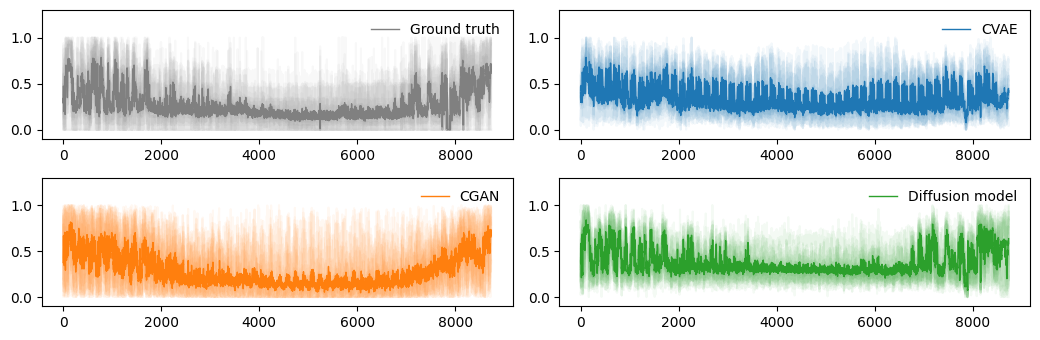

In [ ]:
for idx in selected_meta.index:
  # Extract the conditions from the first row of selected_meta
  condition = selected_meta.loc[idx]
  condition_dict = condition.to_dict()

  # Filter test_metadata based on these conditions
  filtered_test_metadata = test_metadata[
      (test_metadata['lat'] == condition['lat']) &
      (test_metadata['lng'] == condition['lng']) &
      (test_metadata['meter_type'] == condition['meter_type']) &
      (test_metadata['building_type'] == condition['building_type']) &
      (test_metadata['year'] == condition['year'])
  ]

  # Create the figure and axis objects for a 2x2 layout
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10.5, 3.5))

  # Reorganize the title from condition_dict
  organized_title_str = f"{condition_dict['meter_type'].capitalize()} meters in {condition_dict['building_type'].capitalize()} buildings at (lat: {condition_dict['lat']:.2f}, lon: {condition_dict['lng']:.2f})"

  #fig.suptitle(organized_title_str, fontsize=14)
  print(f"{condition_dict['meter_type'].capitalize()} meters in {condition_dict['building_type'].capitalize()} buildings at (lat: {condition_dict['lat']:.2f}, lon: {condition_dict['lng']:.2f})")

  # Plot test_data
  test_data = (test_data-test_data.min())/(test_data.max()-test_data.min())
  test_data[filtered_test_metadata.index].plot(ax=ax1, color='grey', alpha=0.05)
  test_data_avg = test_data[filtered_test_metadata.index].mean(axis=1)
  test_data_avg.rename('Ground truth').plot(ax=ax1, color='grey', linewidth=1)
  #ax1.set_title("Real data of " + organized_title_str)
  ax1.set_ylim(-0.1, 1.3)
  handles, labels = ax1.get_legend_handles_labels()
  ax1.legend([handles[-1]], [labels[-1]], loc='upper right', frameon=False)  # Adjust 'loc' parameter to place the legend at a suitable position

  # Plot CVAE_series (synthetic_series)
  synthetic_series = series_preprocessing(CVAE_series)
  synthetic_series[filtered_test_metadata.index].plot(ax=ax2, color='C0', alpha=0.05)
  synthetic_series_avg = synthetic_series[filtered_test_metadata.index].mean(axis=1)
  synthetic_series_avg.rename('CVAE').plot(ax=ax2, color='C0', linewidth=1)
  #ax2.set_title("Synthetic data by CVAE of " + organized_title_str)
  ax2.set_ylim(-0.1, 1.3)
  handles, labels = ax2.get_legend_handles_labels()
  ax2.legend([handles[-1]], [labels[-1]], loc='upper right', frameon=False)  # Adjust 'loc' parameter to place the legend at a suitable position

  # Plot CGAN_series (Assuming you have the variable)
  # Replace the plot content accordingly
  synthetic_series = series_preprocessing(CGAN_series)
  synthetic_series[filtered_test_metadata.index].plot(ax=ax3, color='C1', alpha=0.05)
  synthetic_series_avg = synthetic_series[filtered_test_metadata.index].mean(axis=1)
  synthetic_series_avg.rename('CGAN').plot(ax=ax3, color='C1', linewidth=1)
  #ax3.set_title("Synthetic data by CGAN of " + organized_title_str)
  ax3.set_ylim(-0.1, 1.3)
  handles, labels = ax3.get_legend_handles_labels()
  ax3.legend([handles[-1]], [labels[-1]], loc='upper right', frameon=False)  # Adjust 'loc' parameter to place the legend at a suitable position

  # Plot Diffusion_series (Assuming you have the variable)
  # Replace the plot content accordingly
  synthetic_series = series_preprocessing(Diffusion_series)
  synthetic_series[filtered_test_metadata.index].plot(ax=ax4, color='C2', alpha=0.05)
  synthetic_series_avg = synthetic_series[filtered_test_metadata.index].mean(axis=1)
  synthetic_series_avg.rename('Diffusion model').plot(ax=ax4, color='C2', linewidth=1)
  #ax4.set_title("Synthetic data by Diffusion of " + organized_title_str)
  ax4.set_ylim(-0.1, 1.3)
  handles, labels = ax4.get_legend_handles_labels()
  ax4.legend([handles[-1]], [labels[-1]], loc='upper right', frameon=False)  # Adjust 'loc' parameter to place the legend at a suitable position

  # Show the plot
  plt.tight_layout()
  figures_path = "./figures"

  # Save the figure to the specified path with 300 dpi resolution
  figure_name = f"results_tsplot{str(idx)}.png"
  full_figure_path = os.path.join(figures_path, figure_name)
  plt.savefig(full_figure_path, dpi=300, bbox_inches='tight')

  plt.show()


Electricity meters in Office buildings at (lat: 44.98, lon: -93.26)


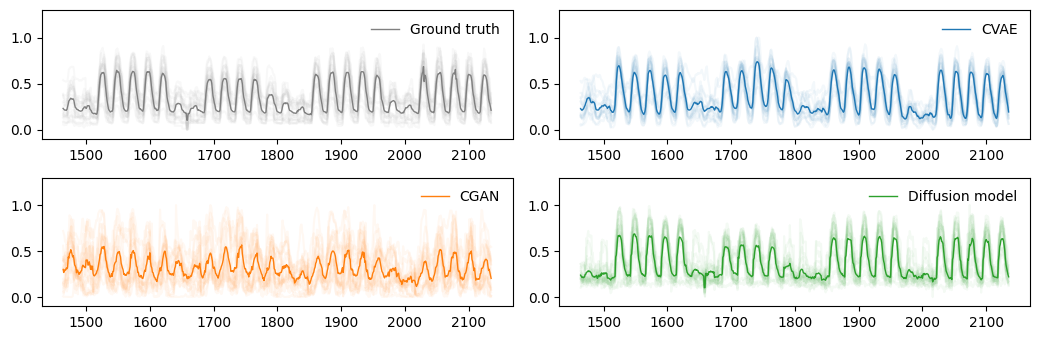

Electricity meters in Education buildings at (lat: 30.27, lon: -97.74)


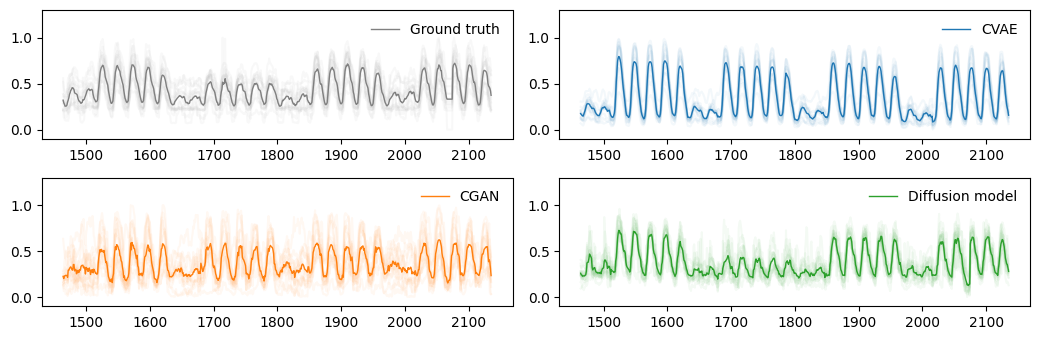

Chilledwater meters in Education buildings at (lat: 33.42, lon: -111.93)


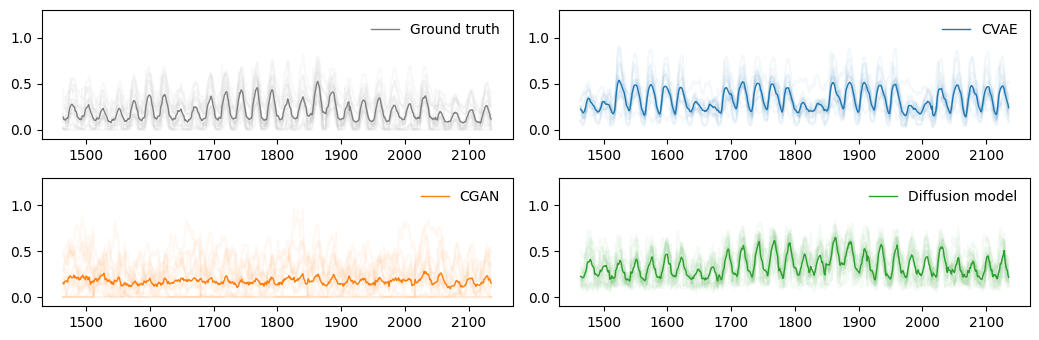

Steam meters in Education buildings at (lat: 30.27, lon: -97.74)


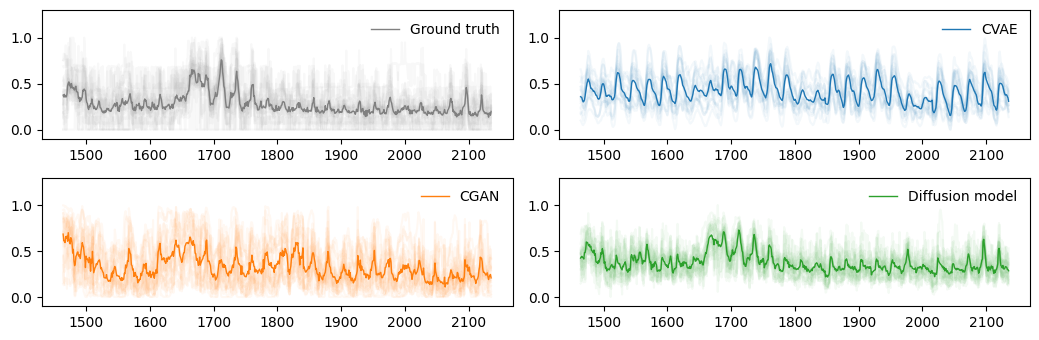

In [ ]:
for idx in selected_meta.index:
  # Extract the conditions from the first row of selected_meta
  condition = selected_meta.loc[idx]
  condition_dict = condition.to_dict()

  # Filter test_metadata based on these conditions
  filtered_test_metadata = test_metadata[
      (test_metadata['lat'] == condition['lat']) &
      (test_metadata['lng'] == condition['lng']) &
      (test_metadata['meter_type'] == condition['meter_type']) &
      (test_metadata['building_type'] == condition['building_type']) &
      (test_metadata['year'] == condition['year'])
  ]

  # Create the figure and axis objects for a 2x2 layout
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10.5, 3.5))

  # Reorganize the title from condition_dict
  organized_title_str = f"{condition_dict['meter_type'].capitalize()} meters in {condition_dict['building_type'].capitalize()} buildings at (lat: {condition_dict['lat']:.2f}, lon: {condition_dict['lng']:.2f})"

  #fig.suptitle(organized_title_str, fontsize=14)
  print(f"{condition_dict['meter_type'].capitalize()} meters in {condition_dict['building_type'].capitalize()} buildings at (lat: {condition_dict['lat']:.2f}, lon: {condition_dict['lng']:.2f})")

  # Plot test_data
  test_data = pd.read_pickle(os.path.join(load_path, 'test_data.pkl'))
  test_data = ((test_data-test_data.min())/(test_data.max()-test_data.min())).iloc[1440+24:1440+29*24]
  test_data[filtered_test_metadata.index].plot(ax=ax1, color='grey', alpha=0.05)
  test_data_avg = test_data[filtered_test_metadata.index].mean(axis=1)
  test_data_avg.rename('Ground truth').plot(ax=ax1, color='grey', linewidth=1)
  #ax1.set_title("Real data of " + organized_title_str)
  ax1.set_ylim(-0.1, 1.3)
  handles, labels = ax1.get_legend_handles_labels()
  ax1.legend([handles[-1]], [labels[-1]], loc='upper right', frameon=False)  # Adjust 'loc' parameter to place the legend at a suitable position

  # Plot CVAE_series (synthetic_series)
  synthetic_series = series_preprocessing(CVAE_series).iloc[1440+24:1440+29*24]
  synthetic_series[filtered_test_metadata.index].plot(ax=ax2, color='C0', alpha=0.05)
  synthetic_series_avg = synthetic_series[filtered_test_metadata.index].mean(axis=1)
  synthetic_series_avg.rename('CVAE').plot(ax=ax2, color='C0', linewidth=1)
  #ax2.set_title("Synthetic data by CVAE of " + organized_title_str)
  ax2.set_ylim(-0.1, 1.3)
  handles, labels = ax2.get_legend_handles_labels()
  ax2.legend([handles[-1]], [labels[-1]], loc='upper right', frameon=False)  # Adjust 'loc' parameter to place the legend at a suitable position

  # Plot CGAN_series (Assuming you have the variable)
  # Replace the plot content accordingly
  synthetic_series = series_preprocessing(CGAN_series).iloc[1440+24:1440+29*24]
  synthetic_series[filtered_test_metadata.index].plot(ax=ax3, color='C1', alpha=0.05)
  synthetic_series_avg = synthetic_series[filtered_test_metadata.index].mean(axis=1)
  synthetic_series_avg.rename('CGAN').plot(ax=ax3, color='C1', linewidth=1)
  #ax3.set_title("Synthetic data by CGAN of " + organized_title_str)
  ax3.set_ylim(-0.1, 1.3)
  handles, labels = ax3.get_legend_handles_labels()
  ax3.legend([handles[-1]], [labels[-1]], loc='upper right', frameon=False)  # Adjust 'loc' parameter to place the legend at a suitable position

  # Plot Diffusion_series (Assuming you have the variable)
  # Replace the plot content accordingly
  synthetic_series = series_preprocessing(Diffusion_series).iloc[1440+24:1440+29*24]
  synthetic_series[filtered_test_metadata.index].plot(ax=ax4, color='C2', alpha=0.05)
  synthetic_series_avg = synthetic_series[filtered_test_metadata.index].mean(axis=1)
  synthetic_series_avg.rename('Diffusion model').plot(ax=ax4, color='C2', linewidth=1)
  #ax4.set_title("Synthetic data by Diffusion of " + organized_title_str)
  ax4.set_ylim(-0.1, 1.3)
  handles, labels = ax4.get_legend_handles_labels()
  ax4.legend([handles[-1]], [labels[-1]], loc='upper right', frameon=False)  # Adjust 'loc' parameter to place the legend at a suitable position

  # Show the plot
  plt.tight_layout()
  figures_path = "./figures"

  # Save the figure to the specified path with 300 dpi resolution
  figure_name = f"results_zoomin_tsplot{str(idx)}.png"
  full_figure_path = os.path.join(figures_path, figure_name)
  plt.savefig(full_figure_path, dpi=300, bbox_inches='tight')

  plt.show()


Electricity meters in Office buildings at (lat: 44.98, lon: -93.26)


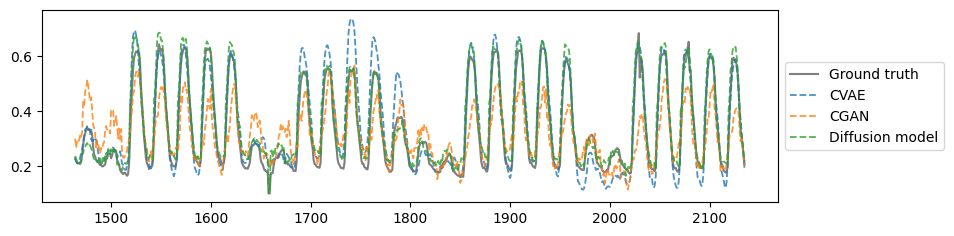

Electricity meters in Education buildings at (lat: 30.27, lon: -97.74)


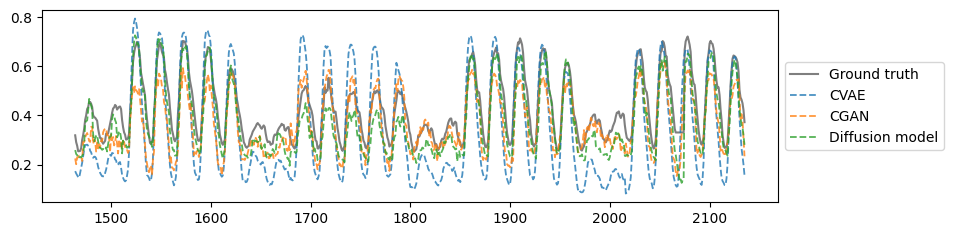

Chilledwater meters in Education buildings at (lat: 33.42, lon: -111.93)


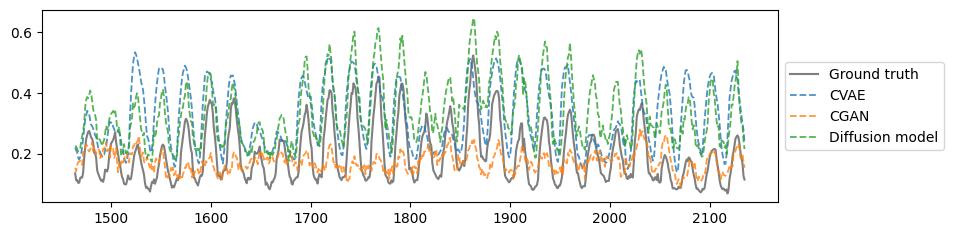

Steam meters in Education buildings at (lat: 30.27, lon: -97.74)


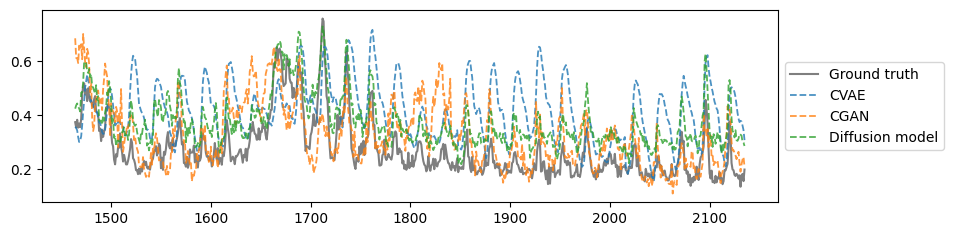

In [ ]:
for idx in selected_meta.index:
  # Extract the conditions from the first row of selected_meta
  condition = selected_meta.loc[idx]
  condition_dict = condition.to_dict()

  # Filter test_metadata based on these conditions
  filtered_test_metadata = test_metadata[
      (test_metadata['lat'] == condition['lat']) &
      (test_metadata['lng'] == condition['lng']) &
      (test_metadata['meter_type'] == condition['meter_type']) &
      (test_metadata['building_type'] == condition['building_type']) &
      (test_metadata['year'] == condition['year'])
  ]

  # Reorganize the title from condition_dict
  organized_title_str = f"{condition_dict['meter_type'].capitalize()} meters in {condition_dict['building_type'].capitalize()} buildings at (lat: {condition_dict['lat']:.2f}, lon: {condition_dict['lng']:.2f})"

  #fig.suptitle(organized_title_str, fontsize=14)
  print(f"{condition_dict['meter_type'].capitalize()} meters in {condition_dict['building_type'].capitalize()} buildings at (lat: {condition_dict['lat']:.2f}, lon: {condition_dict['lng']:.2f})")

  # Plot test_data
  test_data = pd.read_pickle(os.path.join(load_path, 'test_data.pkl'))
  test_data = ((test_data-test_data.min())/(test_data.max()-test_data.min())).iloc[1440+24:1440+29*24]
  test_data_avg = test_data[filtered_test_metadata.index].mean(axis=1)

  # Plot CVAE_series (synthetic_series)
  synthetic_series = series_preprocessing(CVAE_series).iloc[1440+24:1440+29*24]
  synthetic_series_avg1 = synthetic_series[filtered_test_metadata.index].mean(axis=1)

  # Plot CGAN_series (Assuming you have the variable)
  # Replace the plot content accordingly
  synthetic_series = series_preprocessing(CGAN_series).iloc[1440+24:1440+29*24]
  synthetic_series_avg2 = synthetic_series[filtered_test_metadata.index].mean(axis=1)

  # Plot Diffusion_series (Assuming you have the variable)
  # Replace the plot content accordingly
  synthetic_series = series_preprocessing(Diffusion_series).iloc[1440+24:1440+29*24]
  synthetic_series_avg3 = synthetic_series[filtered_test_metadata.index].mean(axis=1)

  df_plot = pd.concat([test_data_avg, synthetic_series_avg1, synthetic_series_avg2, synthetic_series_avg3], axis=1)
  df_plot.columns = ['Ground truth','CVAE','CGAN','Diffusion model']

  # Plotting
  fig = plt.figure(figsize=(9.5, 2.5))

  # Plotting Ground truth with solid line
  plt.plot(df_plot["Ground truth"], label="Ground truth", color='black', linewidth=1.5, alpha=0.5)

  # Plotting other three columns with dashed lines
  plt.plot(df_plot["CVAE"], label="CVAE", linestyle='--', color='C0', linewidth=1.3, alpha=0.8)
  plt.plot(df_plot["CGAN"], label="CGAN", linestyle='--', color='C1', linewidth=1.3, alpha=0.8)
  plt.plot(df_plot["Diffusion model"], label="Diffusion model", linestyle='--', color='C2', linewidth=1.3, alpha=0.8)

  #plt.xlabel('Index')
  #plt.ylabel('Values')
  #plt.title('Comparison')
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.grid(False)

  # Show the plot
  figures_path = "./figures"

  # Save the figure to the specified path with 300 dpi resolution
  figure_name = f"results_comp_tsplot{str(idx)}.png"
  full_figure_path = os.path.join(figures_path, figure_name)
  plt.savefig(full_figure_path, dpi=300, bbox_inches='tight')

  plt.show()


Electricity meters in Office buildings at (lat: 44.98, lon: -93.26)


<ipython-input-22-1210b295edc6>:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


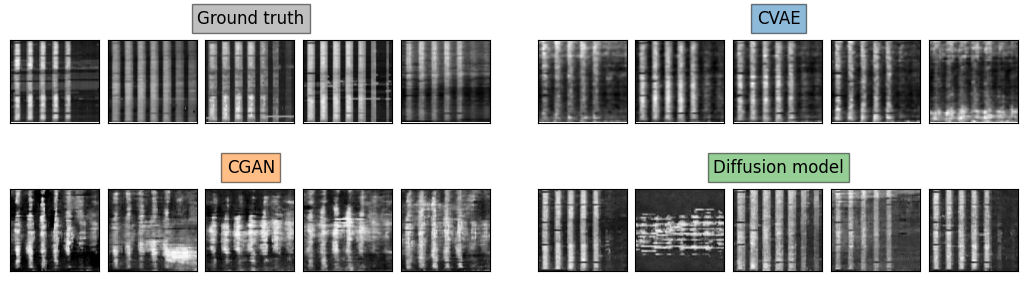

Electricity meters in Education buildings at (lat: 30.27, lon: -97.74)


<ipython-input-22-1210b295edc6>:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


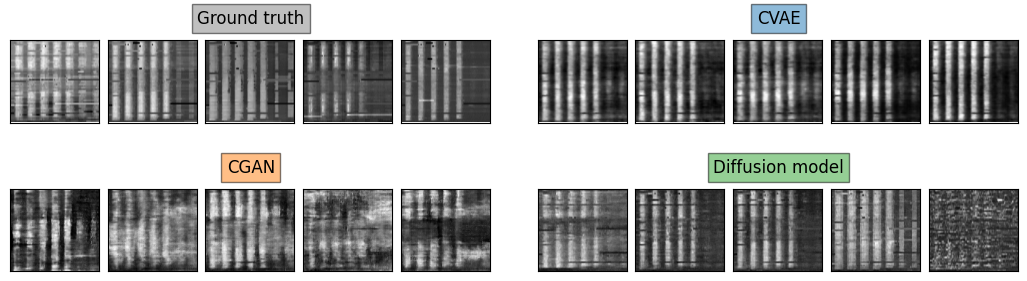

Chilledwater meters in Education buildings at (lat: 33.42, lon: -111.93)


<ipython-input-22-1210b295edc6>:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


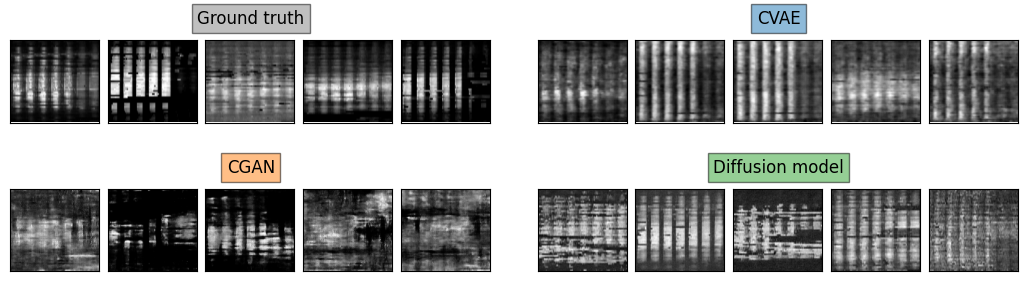

Steam meters in Education buildings at (lat: 30.27, lon: -97.74)


<ipython-input-22-1210b295edc6>:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


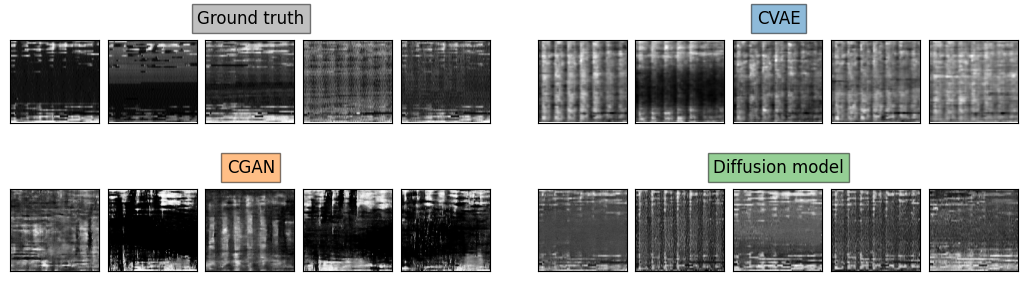

In [ ]:
color_map = {
    'Ground truth': 'grey',
    'CVAE': 'C0',
    'CGAN': 'C1',
    'Diffusion model': 'C2'
}

for idx in selected_meta.index:
    # Extract the conditions from the first row of selected_meta
    condition = selected_meta.loc[idx]
    condition_dict = condition.to_dict()

    # Filter test_metadata based on these conditions
    filtered_test_metadata = test_metadata.reset_index()
    filtered_test_metadata = filtered_test_metadata[
        (filtered_test_metadata['lat'] == condition['lat']) &
        (filtered_test_metadata['lng'] == condition['lng']) &
        (filtered_test_metadata['meter_type'] == condition['meter_type']) &
        (filtered_test_metadata['building_type'] == condition['building_type']) &
        (filtered_test_metadata['year'] == condition['year'])
    ]

    fig = plt.figure(figsize=(13, 3.0))
    outer = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.8)
    #fig.suptitle(f"{condition_dict['meter_type'].capitalize()} meters in {condition_dict['building_type'].capitalize()} buildings at (lat: {condition_dict['lat']:.2f}, lon: {condition_dict['lng']:.2f})", fontsize=14, y=1.1)
    print(f"{condition_dict['meter_type'].capitalize()} meters in {condition_dict['building_type'].capitalize()} buildings at (lat: {condition_dict['lat']:.2f}, lon: {condition_dict['lng']:.2f})")

    for i, method in enumerate(['Ground truth', 'CVAE', 'CGAN', 'Diffusion model']):
        inner = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=outer[i], wspace=0.1, hspace=0.1)
        if method == 'Ground truth':
            images = X_test.copy()
            images = images[filtered_test_metadata.index]
            images = images[5:10, :, :, 0]
            images = np.transpose(images, (1, 2, 0))
        elif method == 'CVAE':
            images = CVAE_images[:,:,:,0].copy()
            images = images[filtered_test_metadata.index]
            images = images[5:10, :, :]
            images = np.transpose(images, (1, 2, 0))
        elif method == 'CGAN':
            images = CGAN_images[:,:,:,0].copy()
            images = images[filtered_test_metadata.index]
            images = images[5:10, :, :]
            images = np.transpose(images, (1, 2, 0))
        elif method == 'Diffusion model':
            images = Diffusion_images[:,:,:,0].copy()
            images = images[filtered_test_metadata.index]
            images = images[5:10, :, :]
            images = np.transpose(images, (1, 2, 0))

        for j in range(5):
            ax = plt.Subplot(fig, inner[j])
            image = images[:, :, j]
            image = (image-image.min())/(image.max()-image.min())
            ax.imshow(image, aspect='auto', cmap='gray')  # Heatmap

            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)

        # Annotate to indicate the method used as a form of legend
        ax.annotate(f"{method}", xy=(-1.69, 1.15), xycoords="axes fraction", va="bottom", ha="center", fontsize=12, bbox=dict(facecolor=color_map[method], alpha=0.5))


    # Show the plot
    plt.tight_layout()
    figures_path = "./figures"

    # Save the figure to the specified path with 300 dpi resolution
    figure_name = f"results_heatmaps{str(idx)}.png"
    full_figure_path = os.path.join(figures_path, figure_name)
    plt.savefig(full_figure_path, dpi=300, bbox_inches='tight')

    plt.show()

